In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats
import scipy.optimize

%matplotlib inline 

import emcee

import seaborn as sns
import pandas as pd

In [2]:
# Applying fully Bayesian model to autocorrelation function of single exponential decay

In [3]:
dls_data = np.loadtxt("100nm.dat", skiprows=1)

# Data is in columns based on angle the data is taken at. The first row labels these columns

tau = dls_data[:,0]
intensity_20 = dls_data[:,1]
intensity_40 = dls_data[:,2]
intensity_60 = dls_data[:,3]
intensity_80 = dls_data[:,4]
intensity_100 = dls_data[:,5]
intensity_120 = dls_data[:,6]
intensity_140 = dls_data[:,7]
intensity_160 = dls_data[:,8]

# Since the instrument stops taking data at the end and drops to 0, get rid of the last 40 points
intensity_20 = intensity_20[:(len(intensity_20)-40)]
intensity_40 = intensity_40[:(len(intensity_40)-40)]
intensity_60 = intensity_60[:(len(intensity_60)-40)]
intensity_80 = intensity_80[:(len(intensity_80)-40)]
intensity_100 = intensity_100[:(len(intensity_100)-40)]
intensity_120 = intensity_120[:(len(intensity_120)-40)]
intensity_140 = intensity_140[:(len(intensity_140)-40)]
intensity_160 = intensity_160[:(len(intensity_160)-40)]

tau = tau[:(len(tau)-40)]

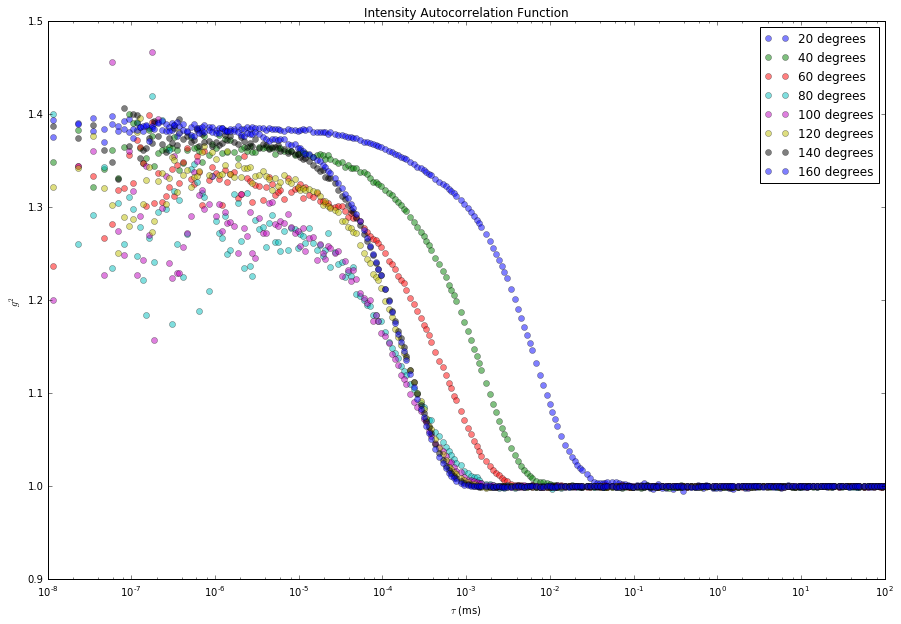

In [4]:
# Now plot all of the data together, to look at the overall trends
fig = plt.figure(figsize = (15, 10))
plt.semilogx(tau, intensity_20, 'o', alpha = 0.5, label= "20 degrees")
plt.semilogx(tau, intensity_40, 'o', alpha = 0.5, label= "40 degrees")
plt.semilogx(tau, intensity_60, 'o', alpha = 0.5, label= "60 degrees")
plt.semilogx(tau, intensity_80, 'o', alpha = 0.5, label= "80 degrees")
plt.semilogx(tau, intensity_100, 'o', alpha = 0.5, label= "100 degrees")
plt.semilogx(tau, intensity_120, 'o', alpha = 0.5, label= "120 degrees")
plt.semilogx(tau, intensity_140, 'o', alpha = 0.5, label= "140 degrees")
plt.semilogx(tau, intensity_160, 'o', alpha = 0.5, label= "160 degrees")
plt.title("Intensity Autocorrelation Function")
plt.xlabel(r'$\tau $ (ms)')
plt.ylabel(r'$g^2$')
plt.legend()

In [5]:
# G(theta, tau) = A exp(-Dq(theta)^2 * tau)
# I need to extract D from all the data simultaneously 


def fitmodel(t, phi, A, C, q, B):

    lam = 658e-9 # wavelength in meters
    phi = phi*(np.pi/180) # scattering angle in radians
    n = 1.333 # refractive index
    
    q = ((4*np.pi * n) /(lam)) * np.sin(phi/2)
    return A*np.e**(-C*q**2*t) + B

#Load in the angles
dls_data = np.loadtxt("100nm.dat", usecols=(1,2,3,4,5,6,7,8))
phi = dls_data[0,:]
phi = phi*(np.pi/180) # scattering angle in radians

########### There are uncertainties in these angles too!!! ###########

In [6]:
# First, I need to assume uniformm error bars in the y direction. 
# Let's say that the intensity autocorrelation function has a constant uncertainty of +-5% of the value

sig_y_20 = intensity_20*0.05
sig_y_40 = intensity_40*0.05
sig_y_60 = intensity_60*0.05
sig_y_80 = intensity_80*0.05
sig_y_100 = intensity_100*0.05
sig_y_120 = intensity_120*0.05
sig_y_140 = intensity_140*0.05
sig_y_160 = intensity_160*0.05

In [7]:
all_data = np.array([intensity_20, intensity_40, intensity_60, intensity_80, 
                     intensity_100, intensity_120, intensity_140, intensity_160])
all_error = np.array([sig_y_20, sig_y_40, sig_y_60, sig_y_80, sig_y_100, sig_y_120, sig_y_140, sig_y_160])


In [15]:
# Now define the log of the liklihood function using the assumption that the prior is equal probablity
def log_prior(theta):
    # returns log of prior probability distribution
    A, D, B = theta # unpack the model parameters
    
    # Set a uniform prior, but within boundaries. It is not equally likely that the baseline is 1 million as it is
    # that it is one. All values must be positive
    if 0 < A < 10.0 and 0.0 < D < 10.0 and 0 < B < 10.0:

        return 0.0  # Since the probability is 1, this returns 0.
    else:
        return -np.inf # Since the probability is 0 in this region, this returns - infinity.
    
    
def log_likelihood(theta, x, phi, y, sig_y):
    # returns the log of the likelihood function

    # theta: model parameters (specified as a tuple)
    # x: tau
    # y: measurements
    # sig_y: uncertainties on measured data, set to be +- 5% of the value
    
    A, D, B = theta # unpack the model parameters
    
    # Using the model A*np.e**(-C* q**2 *t) + B, define the log of the likelihood function as
    # ln (L) = K - 1/2 * Sum [(y- function)^2 / sigma^2] 
    # ln (L) = K - 1/2 Chi^2
    
    lam = 658e-9 # wavelength in meters
    n = 1.333 # refractive index
    q = ((4*np.pi * n) /(lam)) * np.sin(phi/2)

    residual = (y - A*np.e**(-D*q**2*x) - B)**2
    chi_square = np.sum(residual/(sig_y**2))
    
    # the constant K is determined by the Gaussian function 
    constant = np.sum(np.log(1/np.sqrt(2.0*np.pi*sig_y**2)))
        
    
    return constant - 0.5*chi_square

def log_posterior(theta, x, phi, y, sig_y):
    # returns log of posterior probability distribution
    A, D, B = theta # unpack the model parameters
    
    # Bayes Theorem: Posterior = Prior * likelihood
    # Ln (Posterior) = Ln (Prior ) + Ln (Likelihood)
    return log_prior(theta) + log_likelihood(theta, x, phi, y, sig_y)

In [17]:
ndim = 3
nwalkers = 50
nsteps = 500


ls_result = [0.37613228, 8.70222168e-12, 1] # A, D, B
starting_positions = [ls_result + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [18]:
# set up the sampler object for 40 degrees
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(tau, phi[0], intensity_20, sig_y_20))

%time sampler.run_mcmc(starting_positions, nsteps)
print('Done')

CPU times: user 1.31 s, sys: 16.1 ms, total: 1.33 s
Wall time: 1.34 s
Done


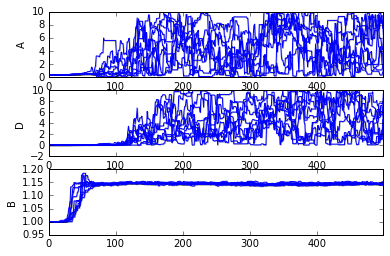

In [20]:
fig, (ax_A, ax_D, ax_B) = plt.subplots(3)
ax_A.set(ylabel='A')
ax_D.set(ylabel='D')
ax_B.set(ylabel='B')
for i in range(10):
    sns.tsplot(sampler.chain[i,:,0], ax=ax_A)
    sns.tsplot(sampler.chain[i,:,1], ax=ax_D)
    sns.tsplot(sampler.chain[i,:,2], ax=ax_B)

In [21]:
# Since it takes about 100 steps for the walkers to settle, trim the data to include only steps after 100
samples = sampler.chain[:,100:,:]

# reshape the samples into a 1D array where the colums are A, D, and B
traces = samples.reshape(-1, ndim).T

# create a pandas DataFrame with labels.
parameter_samples = pd.DataFrame({'A': traces[0], 'D': traces[1], 'B': traces[2]})

In [22]:
# calculate the MAP and values using pandas
q = parameter_samples.quantile([0.16,0.50,0.84], axis=0)

q

,A,B,D
0.16,0.715573,1.140050,0.517924
0.50,4.164047,1.144286,3.527958
0.84,8.212984,1.148237,7.816057


In [23]:
# That's really concerning. The error in the diffusion coefficient is laughably large

# Also concerning is the fit for A, which should be A = 0.376 + 0.008 - 0.008 from previous fits

In [25]:
# So let's go back and try to check on q

theta = phi[0]
lam = 658e-9 # wavelength in meters
n = 1.333 # refractive index
q = ((4*np.pi * n) /(lam)) * np.sin(theta/2)

print q

#D * q**2 = C from previous fit
# D = C / q**2

C = 166.88847569

D = C / q**2 
print D

# Well, that seems pretty reasonable, since the diffusion coeffienct I got before is 8.5 e-12
# Right order of magnitude, so the math of q isn't wrong

# Maybe constrain the prior more? Since it's so damn small, I need to keep it constrained?

4582437.75285
7.94754872898e-12


In [8]:
# Now define the log of the liklihood function using the assumption that the prior is equal probablity
def log_prior(theta):
    # returns log of prior probability distribution
    A, D, B = theta # unpack the model parameters
    
    # Set a uniform prior, but within boundaries. It is not equally likely that the baseline is 1 million as it is
    # that it is one. 
    if 0 < A < 10.0 and -1.0 < D < 1.0 and 0 < B < 10.0:

        return 0.0  # Since the probability is 1, this returns 0.
    else:
        return -np.inf # Since the probability is 0 in this region, this returns - infinity.
    
    
def log_likelihood(theta, x, z, y, sig_y):
    # returns the log of the likelihood function

    # theta: model parameters (specified as a tuple)
    # x: tau
    # y: measurements
    # sig_y: uncertainties on measured data, set to be +- 5% of the value
    
    A, D, B = theta # unpack the model parameters
    
    # Using the model A*np.e**(-C* q**2 *t) + B, define the log of the likelihood function as
    # ln (L) = K - 1/2 * Sum [(y- function)^2 / sigma^2] 
    # ln (L) = K - 1/2 Chi^2
    
    lam = 658e-9 # wavelength in meters
    n = 1.333 # refractive index
    q = ((4*np.pi * n) /(lam)) * np.sin(z/2)

    residual = (y - A*np.e**(-D*(q**2)*x) - B)**2
    chi_square = np.sum(residual/(sig_y**2))
    
    # the constant K is determined by the Gaussian function 
    constant = np.sum(np.log(1/np.sqrt(2.0*np.pi*sig_y**2)))
        
    
    return constant - 0.5*chi_square

def log_posterior(theta, x, z, y, sig_y):
    # returns log of posterior probability distribution
    A, D, B = theta # unpack the model parameters
    
    # Bayes Theorem: Posterior = Prior * likelihood
    # Ln (Posterior) = Ln (Prior ) + Ln (Likelihood)
    return log_prior(theta) + log_likelihood(theta, x, z, y, sig_y)

In [9]:
ndim = 3
nwalkers = 50
nsteps = 500


ls_result = [0.37613228, 8.70222168e-12, 1] # A, D, B
starting_positions = [ls_result + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [10]:
# set up the sampler object for 40 degrees
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(tau, phi[0], intensity_20, sig_y_20))

%time sampler.run_mcmc(starting_positions, nsteps)
print('Done')

CPU times: user 1.43 s, sys: 19.4 ms, total: 1.45 s
Wall time: 1.54 s
Done


/Users/carolinemartin/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


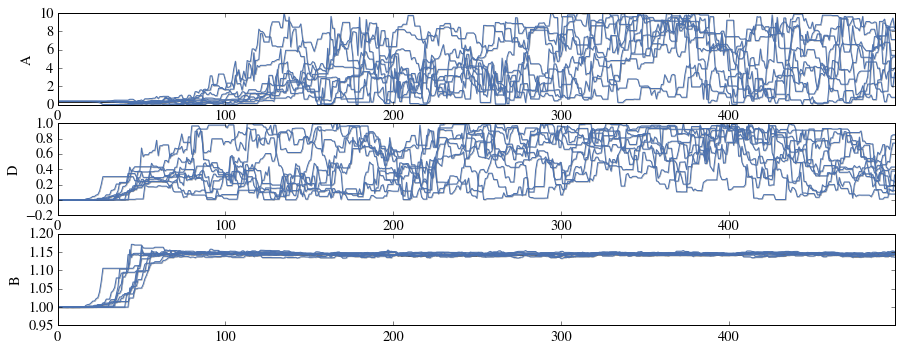

In [11]:
plt.style.use('seaborn-deep')
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5.6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

fig, (ax_A, ax_D, ax_B) = plt.subplots(3)
ax_A.set(ylabel='A')
ax_D.set(ylabel='D')
ax_B.set(ylabel='B')
for i in range(10):
    sns.tsplot(sampler.chain[i,:,0], ax=ax_A)
    sns.tsplot(sampler.chain[i,:,1], ax=ax_D)
    sns.tsplot(sampler.chain[i,:,2], ax=ax_B)

In [12]:
# Since it takes about 100 steps for the walkers to settle, trim the data to include only steps after 100
samples = sampler.chain[:,100:,:]

# reshape the samples into a 1D array where the colums are A, D, and B
traces = samples.reshape(-1, ndim).T

# create a pandas DataFrame with labels.
parameter_samples = pd.DataFrame({'A': traces[0], 'D': traces[1], 'B': traces[2]})

# calculate the MAP and values using pandas
q = parameter_samples.quantile([0.16,0.50,0.84], axis=0)

q

,A,B,D
0.16,1.160298,1.140638,0.165869
0.50,4.600467,1.144754,0.510908
0.84,8.344930,1.148496,0.850479


In [31]:
# That's not any better. So adjusting that doesn't do anything

# Maybe there aren't enough walkers?

ndim = 3
nwalkers = 100
nsteps = 500


ls_result = [0.37613228, 8.70222168e-12, 1] # A, D, B
starting_positions = [ls_result + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [32]:
# set up the sampler object for 40 degrees
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(tau, phi[0], intensity_20, sig_y_20))

%time sampler.run_mcmc(starting_positions, nsteps)
print('Done')

CPU times: user 2.51 s, sys: 20.4 ms, total: 2.53 s
Wall time: 2.55 s
Done


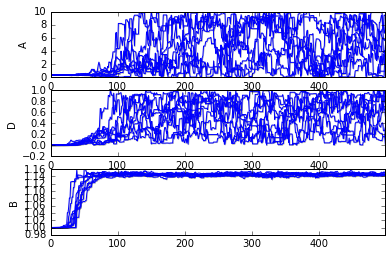

In [33]:
fig, (ax_A, ax_D, ax_B) = plt.subplots(3)
ax_A.set(ylabel='A')
ax_D.set(ylabel='D')
ax_B.set(ylabel='B')
for i in range(10):
    sns.tsplot(sampler.chain[i,:,0], ax=ax_A)
    sns.tsplot(sampler.chain[i,:,1], ax=ax_D)
    sns.tsplot(sampler.chain[i,:,2], ax=ax_B)

In [34]:
## Try fitting a larger number
# Fit to D / lam^2

theta = phi[0]
lam = 658e-9 # wavelength in meters
n = 1.333 # refractive index
q = ((4*np.pi * n) /(lam)) * np.sin(theta/2)

print q

#D * q**2 = C from previous fit
# D = C / q**2

C = 166.88847569

D = C / q**2 

print D / lam**2

4582437.75285
18.356142148


In [35]:
# Not the walkers, it seems. Why is it that A is so uncertain? I understand if it was just D.

# Are the steps taken by the walkers too big? Does it get out of the max, and then can't find its way back? 

# Maybe I can try fitting to D / lam^2 

# A*np.e**(-C* q**2 *t) + B 
#  q = ((4*np.pi * n) /(lam)) * np.sin(z/2)

# exp [ - C 16 pi^2 n^2 / lam^2 * sin^2(theta/2)* tau]

def log_prior(theta):
    # returns log of prior probability distribution
    A, D, B = theta # unpack the model parameters
    
    # Set a uniform prior, but within boundaries. It is not equally likely that the baseline is 1 million as it is
    # that it is one. 
    if 0 < A < 10.0 and -1.0 < D < 100 and 0 < B < 10.0:

        return 0.0  # Since the probability is 1, this returns 0.
    else:
        return -np.inf # Since the probability is 0 in this region, this returns - infinity.
    
    
def log_likelihood(theta, x, z, y, sig_y):
    # returns the log of the likelihood function

    # theta: model parameters (specified as a tuple)
    # x: tau
    # y: measurements
    # sig_y: uncertainties on measured data, set to be +- 5% of the value
    
    A, D, B = theta # unpack the model parameters
    
    # Using the model A*np.e**(-C* q**2 *t) + B, define the log of the likelihood function as
    # ln (L) = K - 1/2 * Sum [(y- function)^2 / sigma^2] 
    # ln (L) = K - 1/2 Chi^2
    
    #lam = 658e-9 # wavelength in meters
    n = 1.333 # refractive index
    #q = ((4*np.pi * n) /(lam)) * np.sin(z/2)
    
    constant = (4*np.pi * n * np.sin(z/2))**2
    
    residual = (y - A*np.e**(-D*constant*x) - B)**2
    chi_square = np.sum(residual/(sig_y**2))
    
    # the constant K is determined by the Gaussian function 
    constant = np.sum(np.log(1/np.sqrt(2.0*np.pi*sig_y**2)))
        
    
    return constant - 0.5*chi_square

def log_posterior(theta, x, z, y, sig_y):
    # returns log of posterior probability distribution
    A, D, B = theta # unpack the model parameters
    
    # Bayes Theorem: Posterior = Prior * likelihood
    # Ln (Posterior) = Ln (Prior ) + Ln (Likelihood)
    return log_prior(theta) + log_likelihood(theta, x, z, y, sig_y)

In [36]:
ndim = 3
nwalkers = 50
nsteps = 500


ls_result = [0.37613228, 18.35, 1.0] # A, D, B
starting_positions = [ls_result + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [37]:
# set up the sampler object for 40 degrees
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(tau, phi[0], intensity_20, sig_y_20))

%time sampler.run_mcmc(starting_positions, nsteps)
print('Done')

CPU times: user 1.31 s, sys: 12.5 ms, total: 1.32 s
Wall time: 1.34 s
Done


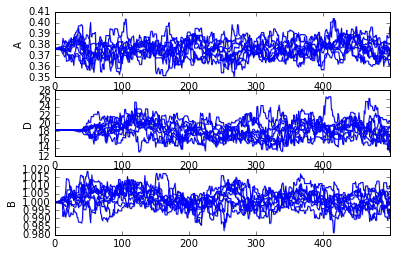

In [38]:
fig, (ax_A, ax_D, ax_B) = plt.subplots(3)
ax_A.set(ylabel='A')
ax_D.set(ylabel='D')
ax_B.set(ylabel='B')
for i in range(10):
    sns.tsplot(sampler.chain[i,:,0], ax=ax_A)
    sns.tsplot(sampler.chain[i,:,1], ax=ax_D)
    sns.tsplot(sampler.chain[i,:,2], ax=ax_B)

In [39]:
# Since it takes about 100 steps for the walkers to settle, trim the data to include only steps after 100
samples = sampler.chain[:,100:,:]

# reshape the samples into a 1D array where the colums are A, D, and B
traces = samples.reshape(-1, ndim).T

# create a pandas DataFrame with labels.
parameter_samples = pd.DataFrame({'A': traces[0], 'D': traces[1], 'B': traces[2]})

# calculate the MAP and values using pandas
q = parameter_samples.quantile([0.16,0.50,0.84], axis=0)

q

,A,B,D
0.16,0.367690,0.996494,16.310311
0.50,0.376160,1.001687,18.262061
0.84,0.383709,1.006980,20.257356


In [ ]:
# Hmmm, moral of the story is that emcee is not that great at fitting one parameter that is orders of magnitude smaller
# than the others. 